# Gaussian Process

## 1. Background

Gaussian process (GP) is a method for estimating targets of unseen data points in a way that undertainty is also considered. More formally, a GP defines a prior over functions, which can be converted into a posterior over functions once we have seen some data.

A GP assumes that $p(f(x1), . . . , f(xN ))$ is jointly Gaussian, with some mean $μ(x)$ and covariance $Σ(x)$ given by $Σ_{ij} = κ(x_i,x_j)$, where $κ$ is a positive definite kernel function. The key idea is that if $x_i$ and $x_j$ are deemed by the kernel to be similar, then we expect the output of the function at those points to be similar too, and if they are dissimilar the output of the function at those points will be dissimilar and uncertain.

<img src="gp.png" height="300" width="300"/>

We can denote a GP as:
    
$f (x) ∼ GP (m(x), κ(x, x′ ))$

where $m(x)$ is the mean function and $κ(x,x′)$ is the kernel or covariance function.

Thus, if we start with a dataset $D = {(x_i,f_i),i = 1 : N}$, where $f_i = f(x_i)$ is the noise-free observation of the function evaluated at $x_i$, we want to predict the function outputs $f_∗$ given a test set $X_∗$ of size $N_∗ × D$.

By definition of the GP, the joint distribution has the following form

$$\binom{f}{f_*} = {\Bigg (}\binom{μ}{μ_*},{\Big (}\begin{matrix}
  K & K_* \\
  K^T & K_{**}
 \end{matrix} {\Big )}{\Bigg )}
 $$
􏰃
where $K = κ(X,X)$ is $N×N$, $K∗ = κ(X,X_∗)$ is $N×N∗$, and $K_{∗∗} = κ(X_∗,X_∗)$ is $N_∗×N_∗$. 

By the standard rules for conditioning Gaussians, the posterior has the following form

\begin{align*} p(f_∗|X_∗,X,f) &= N(f_∗|μ_∗,Σ_∗)\\
μ_∗ &= μ(X_∗) + K^T_∗ K−1(f − μ(X))\\
Σ_∗ &= K_{∗∗} − K^T_∗ K^{−1}K_∗
\end{align*} 

There are many types of kernels that can be used to model the covariance (see [wikipedia article](https://en.wikipedia.org/wiki/Gaussian_process)), a common one is the squared exponential kernel or Gaussian kernal which takes the form:

$$(x,x') =  σ_f^2  exp{\Big (}{\frac{1}{2l^2}(x-x')^2}{\Big )} $$

Here $l$ controls the horizontal length scale over which the function varies, and $σ^f_2$ controls the vertical variation. 
The illustration above shows samples from the posterior, $p(f_∗|X_∗,X,f)$. We see that the model perfectly interpolates the training data, and that the predictive uncertainty increases as we move further away from the observed data.


For a detailed discussion refer to chapter 15 of Kevin Murphy's Machine Learning [Book](https://www.cs.ubc.ca/~murphyk/MLbook/) and Nando de Freitas' youtube [video](https://www.youtube.com/watch?v=MfHKW5z-OOA&index=9&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6&spfreload=1) or the [wikipedia article](https://en.wikipedia.org/wiki/Gaussian_process).

## 2. Noiseless Data Regression Example

The following example implements the formulation presented above assuming no noise in the data. Such that the model interpolates perfectly for training data points and estimates new data points with uncertainty.

Inspired by this [example](http://scikit-learn.org/stable/modules/gaussian_process.html).

In [ ]:
import numpy as np

from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

sigma=1.0
kernels = [sigma * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))]

for fig_index, kernel in enumerate(kernels):
    # Specify Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel)

    # Plot prior
    plt.figure(fig_index, figsize=(8, 8))
    plt.subplot(2, 1, 1)
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')
    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Prior (kernel:  %s)" % kernel, fontsize=12)

    # Generate data and fit GP
    rng = np.random.RandomState(4)
    X = rng.uniform(0, 5, 10)[:, np.newaxis]
    y = np.sin((X[:, 0] - 2.5) ** 2)
    gp.fit(X, y)

    # Plot posterior
    plt.subplot(2, 1, 2)
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)), y_mean + np.sqrt(np.diag(y_cov)),
                     alpha=0.2, color='k')

    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Posterior (kernel: %s)\n Log-Likelihood: %.3f"
              % (gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta)),
              fontsize=12)
    plt.tight_layout()

plt.show()

## 3. Regression Example with Noise in the data

Here we also consider noise in the data and model it using a whitekernel.

Taken from this [example](http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy.html).


In [ ]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel


rng = np.random.RandomState(0)
X = rng.uniform(0, 5, 20)[:, np.newaxis]
y = 0.5 * np.sin(3 * X[:, 0]) + rng.normal(0, 0.5, X.shape[0])

# First run
plt.figure(0)
kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(X, y)
X_ = np.linspace(0, 5, 100)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')
plt.plot(X_, 0.5*np.sin(3*X_), 'r', lw=3, zorder=9)
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

# Second run
plt.figure(1)
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(X, y)
X_ = np.linspace(0, 5, 100)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')
plt.plot(X_, 0.5*np.sin(3*X_), 'r', lw=3, zorder=9)
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

# Plot LML landscape
plt.figure(2)
theta0 = np.logspace(-2, 3, 49)
theta1 = np.logspace(-2, 0, 50)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
LML = [[gp.log_marginal_likelihood(np.log([0.36, Theta0[i, j], Theta1[i, j]]))
        for i in range(Theta0.shape[0])] for j in range(Theta0.shape[1])]
LML = np.array(LML).T

vmin, vmax = (-LML).min(), (-LML).max()
vmax = 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1)
plt.contour(Theta0, Theta1, -LML,
            levels=level, norm=LogNorm(vmin=vmin, vmax=vmax))
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.tight_layout()

plt.show()

From scikit discussion:

This example illustrates that GPR with a sum-kernel including a WhiteKernel can estimate the noise level of data. An illustration of the log-marginal-likelihood (LML) landscape shows that there exist two local maxima of LML. The first corresponds to a model with a high noise level and a large length scale, which explains all variations in the data by noise. The second one has a smaller noise level and shorter length scale, which explains most of the variation by the noise-free functional relationship. The second model has a higher likelihood; however, depending on the initial value for the hyperparameters, the gradient-based optimization might also converge to the high-noise solution. It is thus important to repeat the optimization several times for different initializations.

K=  (10, 10)


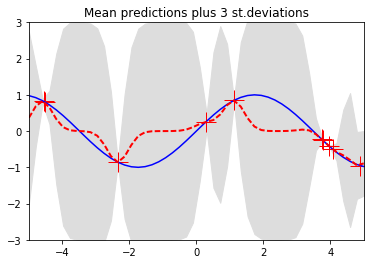

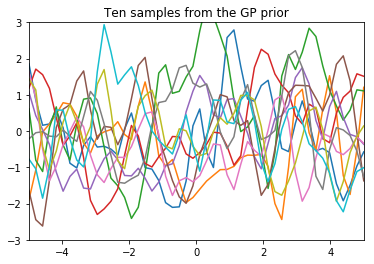

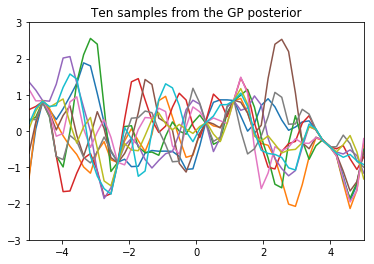

In [48]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
""" This is code for simple GP regression. It assumes a zero mean GP Prior """


# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()
#f = lambda x: (0.25*(x**2)).flatten()


# Define the kernel
def kernel(a, b):
    """ GP squared exponential kernel """
    kernelParameter = 0.1
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    #print("a= ",a, " \n a**2 +b**2 = \n", a**2 + b**2, "b.T= \n ",b.T ,"\n 2*np.dot(a, b.T)= \n ", 2*np.dot(a, b.T))#, "2*np.dot(a, b.T) = ", 2*np.dot(a, b.T))
    #print(" ******************************\n ")
    #print(pd.DataFrame(np.round(sqdist,decimals=2)))
    return np.exp(-.5 * (1/kernelParameter) * sqdist)

N = 10         # number of training points.
n = 50         # number of test points.
s = 0.00005    # noise variance.

# Sample some input points and noisy versions of the function evaluated at
# these points. 
X = np.random.uniform(-5, 5, size=(N,1))
y = f(X) + s*np.random.randn(N)

K = kernel(X, X)
print("K= ", K.shape)
L = np.linalg.cholesky(K + s*np.eye(N))

# points we're going to make predictions at.
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, Xtest))
mu = np.dot(Lk.T, np.linalg.solve(L, y))

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest)
s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
s = np.sqrt(s2)


# PLOTS:
pl.figure(1)
pl.clf()
pl.plot(X, y, 'r+', ms=20)
pl.plot(Xtest, f(Xtest), 'b-')
pl.gca().fill_between(Xtest.flat, mu-3*s, mu+3*s, color="#dddddd")
pl.plot(Xtest, mu, 'r--', lw=2)
pl.savefig('predictive.png', bbox_inches='tight')
pl.title('Mean predictions plus 3 st.deviations')
pl.axis([-5, 5, -3, 3])

# draw samples from the prior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n))
f_prior = np.dot(L, np.random.normal(size=(n,10)))
pl.figure(2)
pl.clf()
pl.plot(Xtest, f_prior)
pl.title('Ten samples from the GP prior')
pl.axis([-5, 5, -3, 3])
pl.savefig('prior.png', bbox_inches='tight')

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,10)))
pl.figure(3)
pl.clf()
pl.plot(Xtest, f_post)
pl.title('Ten samples from the GP posterior')
pl.axis([-5, 5, -3, 3])
pl.savefig('post.png', bbox_inches='tight')

pl.show()

In [18]:
a=1
print(a)

1
